# Predicting Fuel Efficiency of Vehicles

In this series, we'd be going from data collection to deploying the Machine Learning model:

1. **Data Collection** - we are using the classic [Auto MPG dataset](http://archive.ics.uci.edu/ml/datasets/Auto+MPG) from UCI ML Repository.
2. **Define Problem Statement** - We'll frame the problem based on the dataset description and initial exploration.
3. **EDA** - Carry our exploratory analysis to figure out the important features and creating new combination of features.
4. **Data Preparation** - Using step 4, create a pipeline of tasks to transform the data to be loaded into our ML models.
5. **Selecting and Training ML models** - Training a few models to evaluate their predictions using cross-validation.
6. **Hyperparameter Tuning** - Fine tune the hyperparameters for the models that showed promising results.
7. **Deploy the Model using a web service** - Using **Flask web framework** to deploy our trained model on **Heroku**

### Step 1: Collecting Data from UCI ML repository

In [ ]:
!wget "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"

In [ ]:
##importing a few general use case libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# reading the .data file using pandas

cols = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']

df = pd.read_csv('./auto-mpg.data', names=cols, na_values = "?",
                comment = '\t',
                sep= " ",
                skipinitialspace=True)

data = df.copy()

In [ ]:
data.sample(20)

### Problem Statement:

The data contains MPG variable which is continuous data and tells us about the efficiency of fuel consumption of a vehicle in 70s and 80s.

Our aim here is to **predict the MPG value for a vehicle** given we have other attributes of that vehicle.

### Step 3: Exploratory Data Analysis

1. Check for Data type of columns
2. Check for null values.
3. Check for outliers
4. Look for the category distribution in categorical columns
5. Plot for correlation
6. Look for new variables

In [ ]:
##checking the data info
data.info()

In [ ]:
##checking for all the null values
data.isnull().sum()

In [ ]:
##summary statistics of quantitative variables
data.describe()

In [ ]:
sns.boxplot(x=data['Horsepower'])

In [ ]:
##imputing the values with median
median = data['Horsepower'].median()
data['Horsepower'] = data['Horsepower'].fillna(median)
data.info()

In [ ]:
##category distribution
data["Cylinders"].value_counts() / len(data)

In [ ]:
data['Origin'].value_counts()

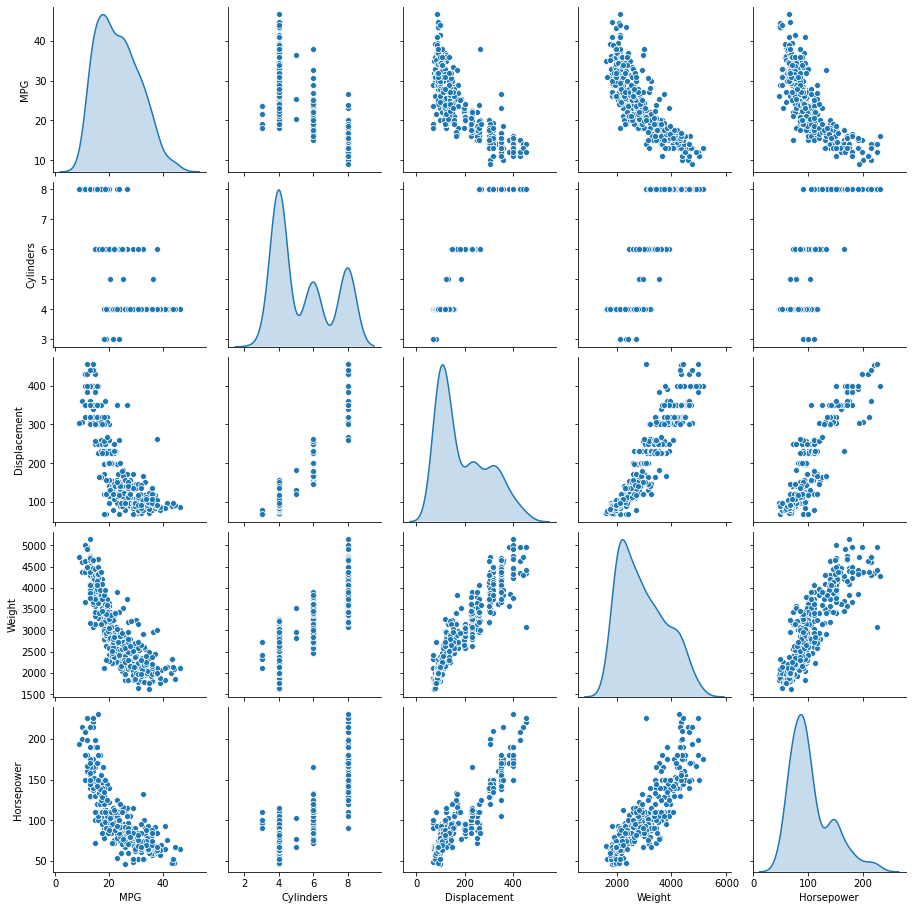

In [73]:
##pairplots to get an intuition of potential correlations
sns.pairplot(data[["MPG", "Cylinders", "Displacement", "Weight", "Horsepower"]], diag_kind="kde")


### Setting aside Test Set

In [75]:
# set aside the test data
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

test_set.shape

(80, 8)

In [76]:
train_set['Cylinders'].value_counts() / len(train_set)

4    0.509434
8    0.248428
6    0.220126
3    0.012579
5    0.009434
Name: Cylinders, dtype: float64

In [77]:
test_set["Cylinders"].value_counts() / len(test_set)

4    0.525
8    0.300
6    0.175
Name: Cylinders, dtype: float64

### Stratified Sampling

In [78]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data["Cylinders"]):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]

In [79]:
strat_test_set.shape

(80, 8)

In [80]:
##checking for cylinder category distribution in training set
strat_train_set['Cylinders'].value_counts() / len(strat_train_set)

4    0.512579
8    0.257862
6    0.210692
5    0.009434
3    0.009434
Name: Cylinders, dtype: float64

In [81]:
##checking for cylinder category distribution in testing set
strat_test_set["Cylinders"].value_counts() / len(strat_test_set)

4    0.5125
8    0.2625
6    0.2125
3    0.0125
Name: Cylinders, dtype: float64

In [82]:
##converting integer classes to countries in Origin column
train_set['Origin'] = train_set['Origin'].map({1: 'India', 2: 'USA', 3 : 'Germany'})
train_set.sample(10)


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
253,20.5,6,200.0,95.0,3155.0,18.2,78,India
379,36.0,4,98.0,70.0,2125.0,17.3,82,India
193,24.0,6,200.0,81.0,3012.0,17.6,76,India
326,43.4,4,90.0,48.0,2335.0,23.7,80,USA
10,15.0,8,383.0,170.0,3563.0,10.0,70,India
371,29.0,4,135.0,84.0,2525.0,16.0,82,India
177,23.0,4,115.0,95.0,2694.0,15.0,75,USA
244,43.1,4,90.0,48.0,1985.0,21.5,78,USA
203,29.5,4,97.0,71.0,1825.0,12.2,76,USA
247,39.4,4,85.0,70.0,2070.0,18.6,78,Germany


In [83]:
##one hot encoding
train_set = pd.get_dummies(train_set, prefix='', prefix_sep='')
train_set.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Germany,India,USA
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,1,0
18,27.0,4,97.0,88.0,2130.0,14.5,70,1,0,0
376,37.0,4,91.0,68.0,2025.0,18.2,82,1,0,0
248,36.1,4,91.0,60.0,1800.0,16.4,78,1,0,0
177,23.0,4,115.0,95.0,2694.0,15.0,75,0,0,1


In [84]:
data = strat_train_set.copy()

### Checking correlation matrix w.r.t. MPG

In [85]:
corr_matrix = data.corr()
corr_matrix['MPG'].sort_values(ascending=False)

MPG             1.000000
Origin          0.582654
Model Year      0.577636
Acceleration    0.411989
Cylinders      -0.765693
Horsepower     -0.776055
Displacement   -0.800063
Weight         -0.822723
Name: MPG, dtype: float64

### Testing new variables by checking their correlation w.r.t. MPG

1. Displacement on Power
2. Weight on cylinder
3. Acceleration on power
4. Acceleration on cylinder

In [86]:
## testing new variables by checking their correlation w.r.t. MPG
data['displacement_on_power'] = data['Displacement'] / data['Horsepower']
data['weight_on_cylinder'] = data['Weight'] / data['Cylinders']
data['acceleration_on_power'] = data['Acceleration'] / data['Horsepower']
data['acceleration_on_cyl'] = data['Acceleration'] / data['Cylinders']

corr_matrix = data.corr()
corr_matrix['MPG'].sort_values(ascending=False)


MPG                      1.000000
acceleration_on_cyl      0.718888
acceleration_on_power    0.696610
Origin                   0.582654
Model Year               0.577636
Acceleration             0.411989
weight_on_cylinder       0.002289
displacement_on_power   -0.564561
Cylinders               -0.765693
Horsepower              -0.776055
Displacement            -0.800063
Weight                  -0.822723
Name: MPG, dtype: float64

## Data Preparation

1. Handling Categorical Functions - OneHotEncoder
2. Data Cleaning - Imputer
3. Attribute Addition - Adding custom transformation
4. Setting up Data Transformation Pipeline for numerical and categorical column.

In [88]:
##handling missing values
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
imputer.fit(data)

SimpleImputer(strategy='median')

In [89]:
imputer.statistics_

array([2.23500000e+01, 4.00000000e+00, 1.46000000e+02, 9.35000000e+01,
       2.84400000e+03, 1.55000000e+01, 7.60000000e+01, 1.00000000e+00,
       1.67609819e+00, 5.45187500e+02, 1.70795455e-01, 3.50000000e+00])

In [90]:
data.median().values

array([2.23500000e+01, 4.00000000e+00, 1.46000000e+02, 9.35000000e+01,
       2.84400000e+03, 1.55000000e+01, 7.60000000e+01, 1.00000000e+00,
       1.67609819e+00, 5.45187500e+02, 1.70795455e-01, 3.50000000e+00])

In [91]:
X = imputer.transform(data)

In [ ]:
data_tr = pd.DataFrame(X, columns=data.columns,
                          index=data.index)